In [1]:
# Some important and mostly-used packages are already installed on Google-Colab.
import numpy as np
import gdal
import matplotlib.pyplot as plt

In [2]:
# Some other packages require installation.
# They can be accessed from Github; or installed using "pip".
!pip install rasterio

# After successful installation, import the package.
import rasterio as rio

     |████████████████████████████████| 19.3 MB 50.8 MB/s 


In [3]:
# Some packages are very large and you don't need to import the entire library.
# Just work with those methods that you'll work through your project.
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

## Data Loading
In the first step, we read our data in Python.

In [48]:
# Use rasterio package to open images.
# Data can be read from Google Drive directory.

Playa = rio.open('Playa_Image.tif')
Playa_array = Playa.read()



GT = rio.open('Playa_Training.tif')
GT_array = GT.read()

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [49]:
Playa_array.shape

(7, 433, 436)

In [50]:
nRows = Playa_array.shape[1]
nCols = Playa_array.shape[2]
Bands = Playa_array.shape[0]

In [51]:
Bands

7

In [52]:
# Deal with outliers
#e.g. ASTER_array[ASTER_array > 60] = np.nan

# Correct for incorrect values (outliers).
#ASTER_array[ASTER_array > 50] = np.nan

#plt.figure(figsize=(10, 7))
#plt.grid(axis='y', alpha=0.75)
#plt.xlabel('Value')
#plt.ylabel('Frequency')
#plt.title('ASTER Histogram')
#n, bins, patches = plt.hist(x=ASTER_array.flatten(), bins=100, color='r',alpha=0.7, rwidth=0.85)

## Data Visualization

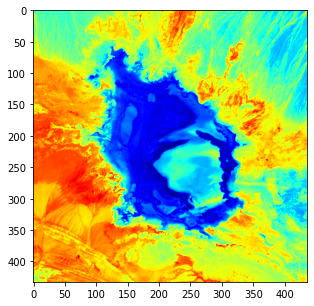

In [53]:
plt.figure(figsize=(5, 5))
plt.imshow(Playa_array[5, :, :], cmap='jet') # cmap='gray'
plt.show()

## Ground Truth (GT)

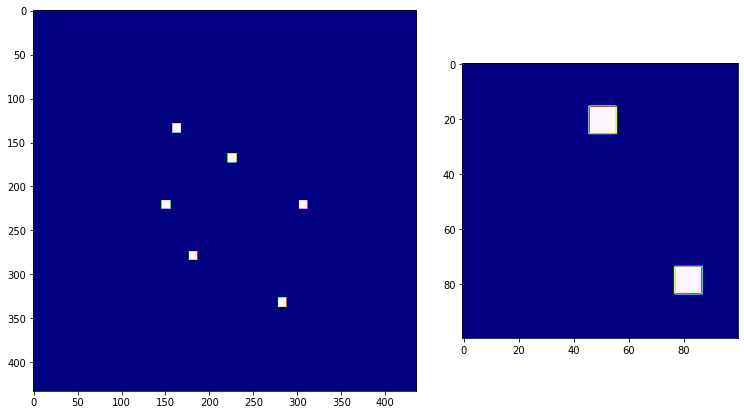

In [54]:
# OK. What's next? Ground truth data
fig = plt.figure(figsize=(13, 7))
gs = fig.add_gridspec(1, 5)
fig.add_subplot(gs[0, :3]), plt.imshow(GT_array[0, :, :], cmap='gist_ncar')
fig.add_subplot(gs[0, -2:]), plt.imshow(GT_array[0, 200:300, 100:200], cmap='gist_ncar')
plt.show()

In [55]:
# Two class classification
list(np.unique(GT_array))

# how many classes?
GT_array[GT_array == 255] = 0
classes = np.unique(GT_array)
print(classes)

[0 1]


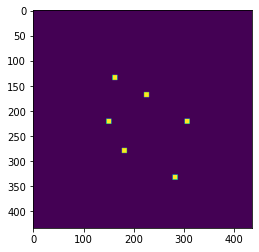

In [56]:
c = 1
cls = np.zeros((nRows, nCols), dtype=int)
cls[GT_array[0, :, :] == 1] = 1

plt.figure()
plt.imshow(cls)
plt.show()

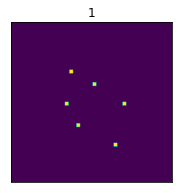

In [57]:
# Take a look at individual classes.
plt.figure(figsize=(10, 10))
plt.tight_layout()
for i in range(len(classes)):
  if i < 1: 
    continue
  C = np.zeros((nRows, nCols))
  C[GT_array[0, :, :] == classes[i]] = 1
  plt.subplot(3, 3, i)
  plt.title(str(classes[i]))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(C)
plt.show()

## Train Test Split

In [58]:
print(GT_array.shape)
print(GT_array.flatten().shape)
print(nRows * nCols)
print(GT_array.flatten()[1000])

(1, 433, 436)
(188788,)
188788
0


In [59]:
for i in range(2):
  if i in classes:
    print(len(np.where(GT_array.flatten() == i)[0]))

# print(len(np.where(GT_array.flatten() == 9)[0]))
# print(len(np.where(GT_array.flatten() == 2)[0]))
# print(len(np.where(GT_array.flatten() == 4)[0]))

188188
600


In [60]:
def split_roi(gt_data, percent):
  import random

  Train = np.zeros_like(gt_data, dtype=int)
  Test = np.zeros_like(gt_data, dtype=int)
  
  labels = list(np.unique(gt_data))
  if 0 in labels: labels.remove(0) 

  for l in labels:
    ind = list(np.where(gt_data.flatten() == l)[0])

    random.shuffle(ind)
    train_inds = ind[:int(percent * len(ind))]
    test_inds = ind[int(percent * len(ind)):]

    temp = np.zeros((nRows*nCols, 1), dtype=int)
    temp[train_inds] = l
    temp = temp.reshape((nRows, nCols))
    Train = Train + temp
    
    temp = np.zeros((nRows*nCols, 1), dtype=int)
    temp[test_inds] = l
    temp = temp.reshape((nRows, nCols))
    Test = Test + temp

  return Train, Test

In [61]:
Train, Test = split_roi(GT_array, 0.7)

In [62]:
# plt.figure(figsize=(10, 10))
# plt.subplot(121), plt.imshow(Train[433], cmap='jet')
# plt.subplot(122), plt.imshow(Test[200:300, 100:200], cmap='jet')
# plt.show()

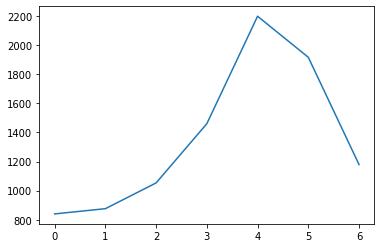

In [63]:
# Also, we can see the spectral curve of a pixel.
plt.plot(Playa_array[:, 200, 300])

In [64]:
# np.mean(Playa_array[:, Train == c][:, :2], axis=1).shape

In [67]:
# Let's try it for a class.
# classes = [1, 2]
# plt.figure(figsize=(15, 15))
# for c in classes:
#   plt.subplot(9, 2, classes.index(c)+1), plt.plot(Playa_array[:, Train == c][:, :10], 'y')
#   plt.plot(np.mean(Playa_array[:, Train == c][:, :10], axis=1), 'k')
#   plt.ylim([0, 12])
# plt.show()

In [77]:
Playa_data  = Playa_array.reshape(Bands, nRows * nCols).T
# [ # observations (# samples / # pixels),  # features]
Train_data   = Train.reshape(1, nRows * nCols).T
Test_data    = Test.reshape(1, nRows * nCols).T

In [78]:
print(Playa_data.shape, Train_data.shape, Test_data.shape)

(188788, 7) (188788, 1) (188788, 1)


In [80]:
# Standardizing data
scaler = StandardScaler()
Playa_standard = scaler.fit(Playa_data)
print(scaler.mean_, scaler.var_)
Playa_standard = Playa_standard.transform(Playa_data)
scaler = StandardScaler()

[1924.64552302 2015.90221836 2396.46986037 2402.94563743 2282.81882323
 2217.08400958 2282.27536708] [ 865763.44655935 1026596.22388579 1622735.95684845 1569902.52765577
 1399036.73017898 1162034.79842791 1110391.69734711]


In [81]:
# You can do the same operation mannually.
# ASTER_standard = np.zeros_like(ASTER_data, dtype=np.float)
# for i in range(48):
#   ASTER_standard[:, i] = (ASTER_data[:, i] - np.mean(ASTER_data[:, i])) / np.std(ASTER_data[:, i])

In [83]:
# See how standardization works.
# plt.figure(figsize=(10, 10))
# for c in classes:
#   plt.subplot(9, 2, classes.index(c)+1), plt.plot(Playa_standard[Train.flatten() == c, :][:10, :].T)
# plt.show()

## Feature Selection and Dimensionality Reduction

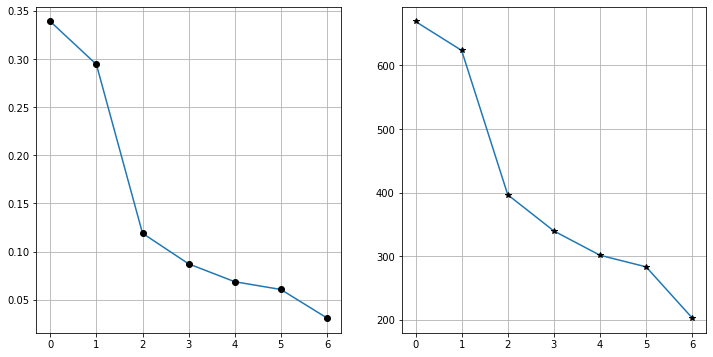

In [85]:
pca = PCA(n_components=7)   # change n components = no of bands
pca.fit(Playa_standard)

variances = pca.explained_variance_ratio_
svds = pca.singular_values_

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.grid(True), plt.plot(variances), plt.plot(variances, 'ok')
plt.subplot(122), plt.grid(True), plt.plot(svds), plt.plot(svds, '*k')
plt.show()

In [86]:
Playa_pca = pca.transform(Playa_standard)
print(Playa_pca.shape)

(188788, 7)


In [88]:
# Extract train and test samples.
#features = np.hstack((Playa_standard)), Playa_pca[:, :3])) # Playa_pca[:, :3] could be included
features = (Playa_standard)
print(features.shape)

features = np.nan_to_num(features)

mask_train = np.zeros((1, nRows, nCols), dtype=int)
mask_test = np.zeros((1, nRows, nCols), dtype=int)

mask_train[Train != 0] = 1
mask_test[Test != 0] = 1

# plt.figure(), plt.imshow(mask_train, cmap='gray')
# plt.figure(), plt.imshow(mask_test, cmap='gray')

train_features = features[np.where(mask_train.flatten() == 1)[0]]
test_features = features[np.where(mask_test.flatten() == 1)[0]]

train_samples = Train_data[np.where(mask_train.flatten() == 1)[0]]
test_samples = Test_data[np.where(mask_test.flatten() == 1)[0]]

(188788, 7)


In [89]:
print(train_features.shape, test_features.shape, train_samples.shape, test_samples.shape)

(420, 7) (180, 7) (420, 1) (180, 1)


In [92]:
n = np.linspace(0, train_features.shape[0], num=420, dtype=int)


In [93]:
clf = svm.SVC(probability=False)
clf.fit(train_features[n[:-1]], train_samples[n[:-1]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: ignored